In [1]:
import pandas as pd
import numpy as np
import time
from pandas import Series
from matplotlib.pyplot import figure
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline
from datetime import datetime, timedelta
import re
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels import tsa
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import calendar
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import patsy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score
import pystan
from fbprophet import Prophet
from sklearn.metrics import r2_score
pd.options.display.max_columns = 100
from sklearn.preprocessing import Imputer
from math import sqrt

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
df = pd.read_csv('Crime_Data.csv')
df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['Occurred Date'],infer_datetime_format=True)
mask1 = (df['date'] > '2007-12-31') & (df['date'] < '2018-12-31')
df = df.loc[mask1] 
df = df[['Crime Subcategory', 'date']]
dfg = df.groupby(['date']).count()
dfg['date']=dfg.index
dfw = dfg.resample('W').sum()
dfw=dfw[1:]
dfw=dfw[:-1]
series = dfw['Crime Subcategory']
dfw.rename(columns={'Crime Subcategory': 'number_crimes'}, inplace=True)
dfw

/anaconda3/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


,number_crimes
date,
2008-01-13,787
2008-01-20,743
2008-01-27,718
2008-02-03,657
2008-02-10,689
2008-02-17,755
2008-02-24,783
2008-03-02,786
2008-03-09,742


In [3]:
mask1 = (df['date'] > '2008-01-12') & (df['date'] < '2018-12-31')
df = df.loc[mask1] 
df.head()

,Crime Subcategory,date
2438,ROBBERY-COMMERCIAL,2008-01-13
2439,ROBBERY-STREET,2008-01-13
2440,AGGRAVATED ASSAULT,2008-01-13
2441,CAR PROWL,2008-01-13
2442,THEFT-BUILDING,2008-01-13


## Prophet

In [6]:
dfw['y']=dfw['number_crimes']
dfw['ds']=dfw.index

In [7]:
dfw.head()

,number_crimes,y,ds
date,,,
2008-01-13,787,787,2008-01-13
2008-01-20,743,743,2008-01-20
2008-01-27,718,718,2008-01-27
2008-02-03,657,657,2008-02-03
2008-02-10,689,689,2008-02-10


In [8]:
dfw.tail()

,number_crimes,y,ds
date,,,
2018-07-29,988,988,2018-07-29
2018-08-05,1034,1034,2018-08-05
2018-08-12,929,929,2018-08-12
2018-08-19,886,886,2018-08-19
2018-08-26,887,887,2018-08-26


In [9]:
weekly = dfw[['ds','y']]
weekly

,ds,y
date,,
2008-01-13,2008-01-13,787
2008-01-20,2008-01-20,743
2008-01-27,2008-01-27,718
2008-02-03,2008-02-03,657
2008-02-10,2008-02-10,689
2008-02-17,2008-02-17,755
2008-02-24,2008-02-24,783
2008-03-02,2008-03-02,786
2008-03-09,2008-03-09,742


In [10]:
weekly_train = weekly[:-150]
m1 = Prophet(seasonality_mode='additive').fit(weekly_train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [297]:
future = m1.make_future_dataframe(periods = 150, freq='W', include_history=True)
future.head()

,ds
0,2008-01-13
1,2008-01-20
2,2008-01-27
3,2008-02-03
4,2008-02-10


In [298]:
future.tail()

,ds
550,2018-07-29
551,2018-08-05
552,2018-08-12
553,2018-08-19
554,2018-08-26


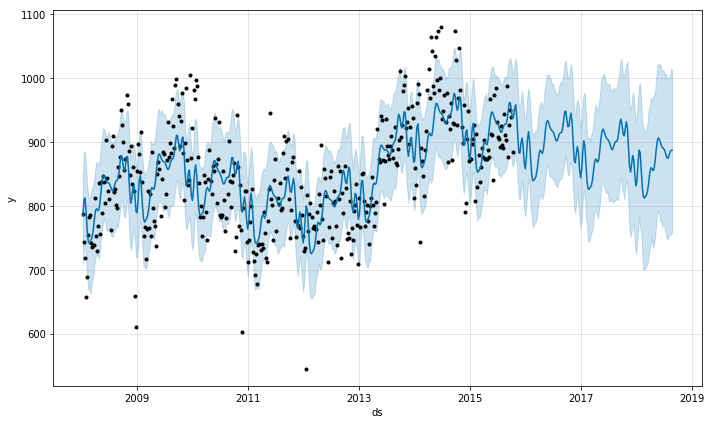

In [299]:
fcst = m1.predict(future)
fig = m1.plot(fcst)


In [300]:
y_test = dfw['y'][-150:]
y_pred = fcst['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

93.75307387008222

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


68.20305006420735

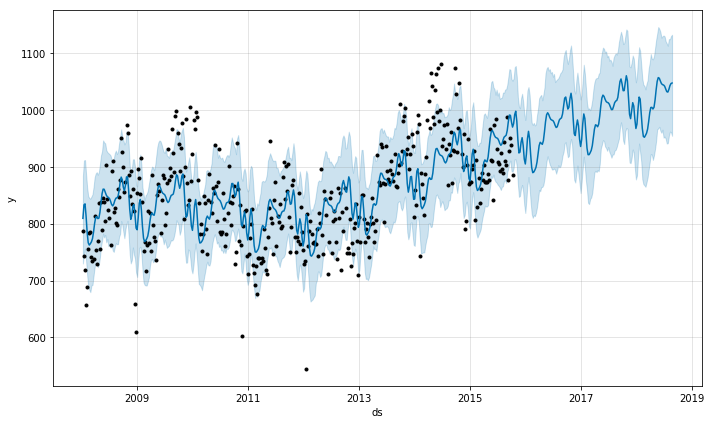

In [301]:
m = Prophet(changepoint_prior_scale=0.03)
forecast = m.fit(weekly_train).predict(future)
fig = m1.plot(forecast)
y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [302]:
rmse_vals = []
for i in range(50):
    m = Prophet(changepoint_prior_scale=.03, yearly_seasonality=i)
    m.fit(weekly_train)
    forecast = m.predict(future)
    y_test = dfw['y'][-150:]
    y_pred = forecast['yhat'][-150:]
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_vals.append(rmse)
    
    

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Di

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

In [303]:
list(enumerate(rmse_vals))

[(0, 81.24215824139534),
 (1, 75.41753536131158),
 (2, 75.4203024697701),
 (3, 71.45673511144305),
 (4, 74.25863128322655),
 (5, 70.74646142154431),
 (6, 70.2363707792979),
 (7, 74.15408769812),
 (8, 70.03048220331223),
 (9, 72.10499522453503),
 (10, 68.20305006420735),
 (11, 69.43304677561204),
 (12, 61.330289201170054),
 (13, 61.1485504440038),
 (14, 62.26287297174544),
 (15, 60.58309703966286),
 (16, 63.5801740060054),
 (17, 59.33149602068523),
 (18, 61.568354859643385),
 (19, 61.06675972144858),
 (20, 63.0077793582358),
 (21, 60.66300538517931),
 (22, 63.30260059369589),
 (23, 65.78866512394355),
 (24, 63.894660381141534),
 (25, 63.17509855565701),
 (26, 65.66664511674036),
 (27, 64.97660987344884),
 (28, 67.3378153248262),
 (29, 58.61135641878391),
 (30, 59.34705295552333),
 (31, 61.341026408335175),
 (32, 62.65819402032883),
 (33, 69.38802942972774),
 (34, 66.78665007479829),
 (35, 61.70569612558408),
 (36, 63.84954036286156),
 (37, 70.20686088074306),
 (38, 69.23460779473271),
 

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


58.61135641878391

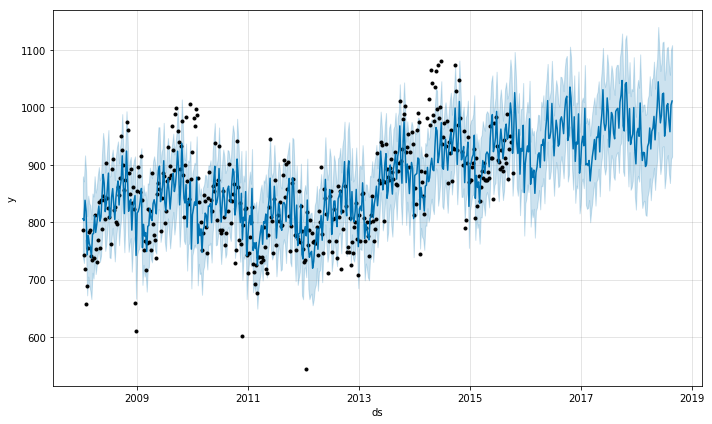

In [304]:
from fbprophet.plot import plot_yearly

m = Prophet(changepoint_prior_scale=.03, yearly_seasonality=29)
m.fit(weekly_train)
forecast = m.predict(future)
fig = m.plot(forecast)

y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [305]:
rmse_vals = []
for i in np.linspace(0.7,0.9,21):
    m = Prophet(changepoint_prior_scale=.03, yearly_seasonality=29,changepoint_range=i)
    m.fit(weekly_train)
    forecast = m.predict(future)
    y_test = dfw['y'][-150:]
    y_pred = forecast['yhat'][-150:]
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_vals.append(rmse)
    

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Di

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


58.67813691711065

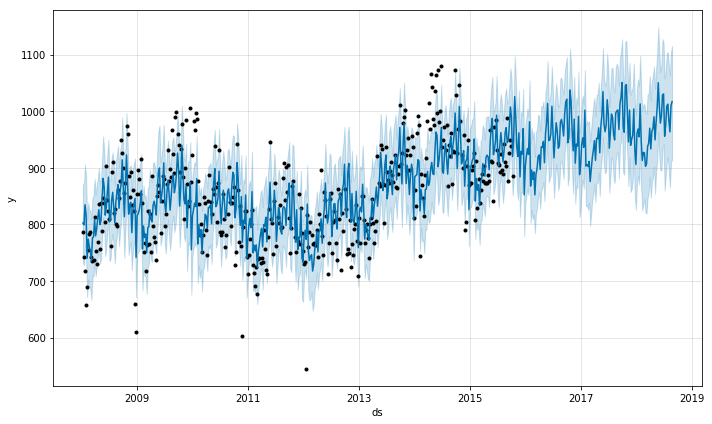

In [307]:
m = Prophet(changepoint_prior_scale=.03, yearly_seasonality=29,changepoint_range=0.78)
m.fit(weekly_train)
forecast = m.predict(future)
fig = m.plot(forecast)

y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [308]:
sorted((weekly['y']))

[545,
 602,
 610,
 657,
 659,
 677,
 689,
 692,
 709,
 712,
 712,
 712,
 714,
 717,
 718,
 719,
 719,
 725,
 725,
 728,
 729,
 730,
 730,
 731,
 734,
 734,
 735,
 737,
 738,
 738,
 739,
 740,
 740,
 741,
 742,
 743,
 743,
 743,
 744,
 746,
 746,
 746,
 746,
 747,
 748,
 749,
 749,
 750,
 751,
 751,
 752,
 752,
 752,
 753,
 753,
 755,
 756,
 757,
 757,
 760,
 760,
 761,
 762,
 762,
 763,
 764,
 764,
 765,
 766,
 766,
 766,
 767,
 767,
 767,
 768,
 768,
 768,
 768,
 769,
 769,
 769,
 770,
 770,
 775,
 776,
 776,
 777,
 777,
 777,
 780,
 781,
 782,
 782,
 782,
 782,
 783,
 784,
 785,
 786,
 786,
 786,
 787,
 787,
 788,
 788,
 789,
 790,
 790,
 791,
 791,
 791,
 792,
 793,
 794,
 796,
 796,
 796,
 797,
 797,
 798,
 798,
 800,
 800,
 800,
 801,
 801,
 801,
 801,
 802,
 802,
 803,
 803,
 804,
 804,
 804,
 805,
 805,
 806,
 807,
 808,
 808,
 808,
 809,
 809,
 810,
 810,
 810,
 811,
 812,
 812,
 812,
 813,
 813,
 815,
 815,
 817,
 819,
 819,
 819,
 819,
 819,
 820,
 821,
 823,
 823,
 823,
 823

In [309]:
weekly[(weekly['y']==1127)]

,ds,y
date,,
2017-07-02,2017-07-02,1127


In [12]:
df = pd.read_csv('Crime_Data.csv')
df = pd.DataFrame(df)
df['date'] = pd.to_datetime(df['Occurred Date'],infer_datetime_format=True)
mask1 = (df['date'] > '2015-06-20') & (df['date'] < '2015-08-11')
df = df.loc[mask1] 
df = df[['Crime Subcategory', 'date']]
dfg = df.groupby(['date']).count()
dfg['date']=dfg.index
dfg

/anaconda3/lib/python3.6/site-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


,Crime Subcategory,date
date,,
2015-06-21,125,2015-06-21
2015-06-22,115,2015-06-22
2015-06-23,151,2015-06-23
2015-06-24,121,2015-06-24
2015-06-25,129,2015-06-25
2015-06-26,138,2015-06-26
2015-06-27,152,2015-06-27
2015-06-28,126,2015-06-28
2015-06-29,146,2015-06-29


In [42]:
weekpt.head()

,ds,y,temp,prec
date,,,,
2008-01-13,2008-01-13,787,42.161250,0.008951
2008-01-20,2008-01-20,743,37.983367,0.002260
2008-01-27,2008-01-27,718,33.490916,0.001154
2008-02-03,2008-02-03,657,38.048619,0.003296
2008-02-10,2008-02-10,689,43.034533,0.006571


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


60.8517307669035

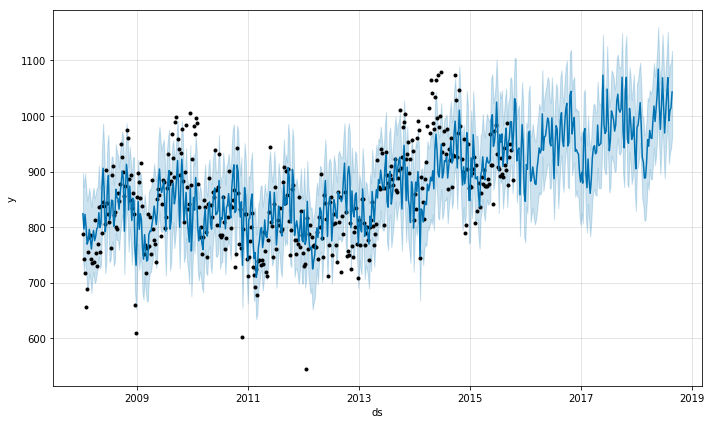

In [51]:
dfplus = pd.read_csv('dfplus.csv')
dfplus.index = dfplus['date']
weekpt = weekly.join(dfplus['temp'])
weekpt = weekpt.join(dfplus['prec'])
weekpt_train = weekpt[:-150]

m = Prophet(changepoint_prior_scale=.02, yearly_seasonality=23)
#m.add_regressor('prec')
m.add_regressor('temp')
m.fit(weekpt_train)

future = weekpt[['ds','temp']]
forecast = m.predict(future)

fig = m.plot(forecast)

y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

In [54]:
rmse_vals = []
for i in np.linspace(20,30,11):
    m = Prophet(changepoint_prior_scale=.02, yearly_seasonality=i)
    m.add_regressor('temp')
    m.fit(weekpt_train)
    future = weekpt[['ds','temp']]
    forecast = m.predict(future)
    y_test = dfw['y'][-150:]
    y_pred = forecast['yhat'][-150:]
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_vals.append(rmse)



INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Di

In [57]:
list(enumerate(rmse_vals))

[(0, 61.23370743891347),
 (1, 60.93933743135272),
 (2, 60.95367231695602),
 (3, 60.8517307669035),
 (4, 60.87264356075502),
 (5, 60.84631860601803),
 (6, 60.62083141555485),
 (7, 60.6834535228019),
 (8, 61.03486136124438),
 (9, 61.19873233155401),
 (10, 61.29263182599554)]

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


60.62083141555485

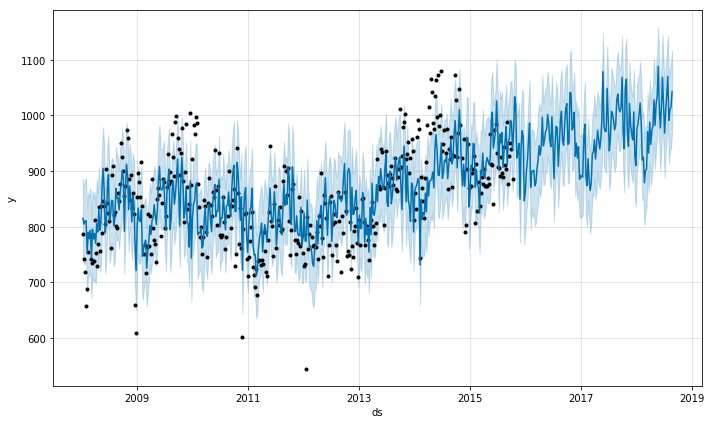

In [65]:
dfplus = pd.read_csv('dfplus.csv')
dfplus.index = dfplus['date']
weekpt = weekly.join(dfplus['temp'])
weekpt = weekpt.join(dfplus['prec'])
weekpt_train = weekpt[:-150]

m = Prophet(changepoint_prior_scale=.02, yearly_seasonality=26)
#m.add_regressor('prec')
m.add_regressor('temp')
m.fit(weekpt_train)

future = weekpt[['ds','temp','prec']]
forecast = m.predict(future)

fig = m.plot(forecast)

y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse



INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


61.19873233155401

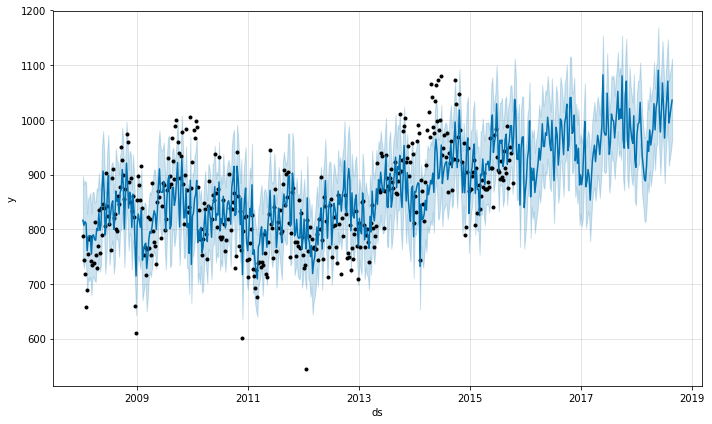

In [12]:
dfplus = pd.read_csv('dfplus.csv')
dfplus.index = dfplus['date']
weekpt = weekly.join(dfplus['temp'])
weekpt = weekpt.join(dfplus['prec'])
weekpt_train = weekpt[:-150]

m = Prophet(changepoint_prior_scale=.02, yearly_seasonality=29)
#m.add_regressor('prec')
m.add_regressor('temp')
m.fit(weekpt_train)

future = weekpt[['ds','temp','prec']]
forecast = m.predict(future)

fig = m.plot(forecast)

y_test = dfw['y'][-150:]
y_pred = forecast['yhat'][-150:]
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse



## OLS

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=3).mean()
    rolstd = timeseries.rolling(window=3).std()

    #Plot rolling statistics:
    plt.figure(figsize=[18,4]) 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [11]:
dfw_train=dfw[:-150]

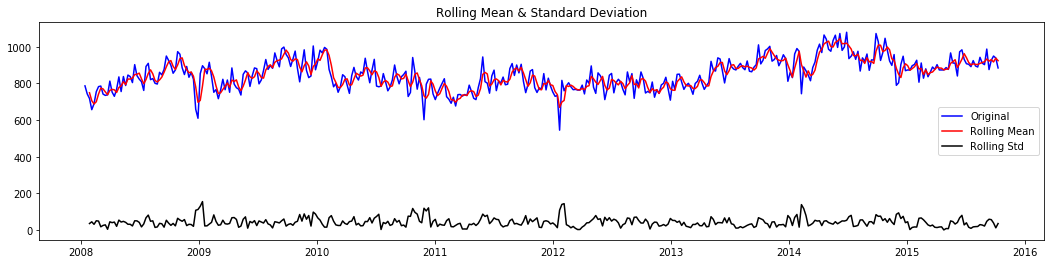

Results of Dickey-Fuller Test:
Test Statistic                  -3.872603
p-value                          0.002246
#Lags Used                       3.000000
Number of Observations Used    401.000000
Critical Value (1%)             -3.446763
Critical Value (5%)             -2.868775
Critical Value (10%)            -2.570624
dtype: float64


In [69]:
test_stationarity(Series(dfw_train['number_crimes']))

In [13]:
weekpt

,ds,y,temp,prec
date,,,,
2008-01-13,2008-01-13,787,42.161250,0.008951
2008-01-20,2008-01-20,743,37.983367,0.002260
2008-01-27,2008-01-27,718,33.490916,0.001154
2008-02-03,2008-02-03,657,38.048619,0.003296
2008-02-10,2008-02-10,689,43.034533,0.006571
2008-02-17,2008-02-17,755,43.063881,0.000179
2008-02-24,2008-02-24,783,44.080252,0.000000
2008-03-02,2008-03-02,786,47.138508,0.001662
2008-03-09,2008-03-09,742,44.696328,0.000563


In [14]:
dfols = weekpt.reset_index()

In [15]:
dfols['startdate'] = dfols.index

In [16]:
dfols

,date,ds,y,temp,prec,startdate
0,2008-01-13,2008-01-13,787,42.161250,0.008951,0
1,2008-01-20,2008-01-20,743,37.983367,0.002260,1
2,2008-01-27,2008-01-27,718,33.490916,0.001154,2
3,2008-02-03,2008-02-03,657,38.048619,0.003296,3
4,2008-02-10,2008-02-10,689,43.034533,0.006571,4
5,2008-02-17,2008-02-17,755,43.063881,0.000179,5
6,2008-02-24,2008-02-24,783,44.080252,0.000000,6
7,2008-03-02,2008-03-02,786,47.138508,0.001662,7
8,2008-03-09,2008-03-09,742,44.696328,0.000563,8
9,2008-03-16,2008-03-16,735,44.651340,0.008451,9


In [73]:
y = dfols['y']
X1 = dfols[['temp', 'prec','startdate']]
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=150, random_state=42)
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

In [74]:
model1 = LinearRegression()
model1.fit(X1_train, y_train)
y1_pred = model1.predict(X1_test)
print (model1.score(X1_test, y_test))
print (model1.score(X1_train, y_train))
print(sqrt(mean_squared_error(y_test, y1_pred)))

0.37033169889676787
0.414232398993563
74.01505219673852


In [17]:
y = dfols['y']
X2 = dfols[['startdate']]
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=150, random_state=42)
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

In [19]:
X2_test

array([[-3.11101463e-01],
       [ 5.97447840e-01],
       [-1.42931599e+00],
       [ 6.41922282e-01],
       [-1.33401362e+00],
       [ 5.72033874e-01],
       [ 6.10154824e-01],
       [-1.26412521e+00],
       [ 1.48058318e+00],
       [ 1.41069477e+00],
       [-9.46450626e-01],
       [-1.29589267e+00],
       [ 3.43308175e-01],
       [-5.39827162e-01],
       [ 1.25821097e+00],
       [-7.74906352e-01],
       [-4.57231771e-01],
       [-1.71522311e+00],
       [-1.28318568e+00],
       [ 3.68722142e-01],
       [ 1.30268541e+00],
       [ 1.27091795e+00],
       [-1.74063708e+00],
       [-6.54190011e-01],
       [-1.45910681e-01],
       [-7.43138894e-01],
       [ 5.08498957e-01],
       [ 9.78657338e-01],
       [-1.23235775e+00],
       [ 7.75345606e-01],
       [ 2.56335934e-02],
       [ 1.47422969e+00],
       [ 2.41652309e-01],
       [-1.31495314e+00],
       [ 1.67118793e+00],
       [-9.08329676e-01],
       [-1.58815328e+00],
       [ 9.91364321e-01],
       [-4.3

In [18]:
model2 = LinearRegression()
model2.fit(X2_train, y_train)
y2_pred = model2.predict(X2_test)
print (model2.score(X2_test, y_test))
print (model2.score(X2_train, y_train))
print(sqrt(mean_squared_error(y_test, y2_pred)))

0.2962743543283334
0.37301739377226045
78.24666271371231


In [85]:
y = dfols['y']
X3 = dfols[['temp','startdate']]
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=150, random_state=42)
scaler = StandardScaler()
X3_train = scaler.fit_transform(X3_train)
X3_test = scaler.transform(X3_test)

In [86]:
model3 = LinearRegression()
model3.fit(X3_train, y_train)
y3_pred = model3.predict(X3_test)
print (model3.score(X3_test, y_test))
print (model3.score(X3_train, y_train))
print(sqrt(mean_squared_error(y_test, y3_pred)))

0.3716315074055865
0.4135034472482173
73.93861902203005


In [354]:
y = dfols['y']
X4 = dfols[['prec','startdate']]
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=150, random_state=42)
scaler = StandardScaler()
X4_train = scaler.fit_transform(X4_train)
X4_test = scaler.transform(X4_test)

In [356]:
model4 = LinearRegression()
model4.fit(X4_train, y_train)
y4_pred = model4.predict(X4_test)
print (model4.score(X4_test, y_test))
print (model4.score(X4_train, y_train))
print(sqrt(mean_squared_error(y_test, y4_pred)))

0.30529715993926854
0.3750393921423376
77.74342536381529


In [91]:
est3 = LinearRegression()
degree = 5
p3 = PolynomialFeatures(degree)
a3 = p3.fit_transform(X3_train)
s3 = StandardScaler()
s3.fit(a3)
X3t_train = s3.transform(a3)
est3.fit(X3t_train, y_train)

b3 = p3.fit_transform(X3_test)
X3t_test= s3.transform(b3)
y_pred = est3.predict(X3t_test)

print(est3.coef_)
print()
print ('RMSE:')
print(sqrt(mean_squared_error(y_test, y_pred)))

[   0.           30.15220467  175.39812664   -6.31063674  -12.40583186
   52.39186872  -17.4152824     6.1517986    -6.42823467 -315.85692133
    4.50233207   -7.41471829  -13.74427723   11.07855217  -32.06220913
    8.19084877  -10.01982006   -3.06148138   10.66120655    4.79198216
  195.28110074]

RMSE:
70.18320060537836


In [83]:
estn = LinearRegression()
degree = 9
pn = PolynomialFeatures(degree)
an = pn.fit_transform(X2_train)
sn = StandardScaler()
sn.fit(an)
X2t_train = sn.transform(an)
estn.fit(X2t_train, y_train)

bn = pn.fit_transform(X2_test)
Xnt_test= sn.transform(bn)
y_pred = estn.predict(Xnt_test)

print(estn.coef_)
print()
print ('RMSE:')
print(sqrt(mean_squared_error(y_test, y_pred)))

[    0.           284.72609208   -35.42730521 -1149.34331396
   238.26357456  2432.70379151  -282.35079012 -2390.94957695
    88.62224781   889.70388258]

RMSE:
65.98882600749285


In [ ]:
est2 = LinearRegression()
degree = 5
p4 = PolynomialFeatures(degree)
a4 = p4.fit_transform(X3_train)
s4 = StandardScaler()
s4.fit(a4)
X3t_train = s4.transform(a4)
est4.fit(X3t_train, y_train)

b4 = p4.fit_transform(X3_test)
X3t_test= s4.transform(b4)
y_pred = est4.predict(X3t_test)

print(est4.coef_)
print()
print ('RMSE:')
print(sqrt(mean_squared_error(y_test, y_pred)))

In [78]:
est5 = LinearRegression()
degree = 7
p5 = PolynomialFeatures(degree)
a5 = p5.fit_transform(X3_train)
s5 = StandardScaler()
s5.fit(a5)
X3t_train = s5.transform(a5)
est5.fit(X3t_train, y_train)

b5 = p5.fit_transform(X3_test)
X3t_test= s5.transform(b5)
y_pred = est5.predict(X3t_test)

print(est5.coef_)
print()
print ('RMSE:')
print(sqrt(mean_squared_error(y_test, y_pred)))

[-1.18532528e+15  6.34301490e+01  2.48784042e+02  2.29504106e+01
 -2.77959945e+01 -1.52438975e+01 -1.43060974e+02  1.65142890e+01
 -1.28350958e+02 -7.25348303e+02 -8.45208089e+01  2.28780864e+01
 -1.67837945e+01 -5.78220514e+01  1.94294235e+02  2.03750412e+02
 -8.33421880e+01  1.21056879e+02  1.21577826e+02  1.45481153e+02
  8.72104976e+02  1.12188265e+02 -7.93708922e+01 -2.42990055e+01
  5.01438265e+01 -2.01363198e+00  6.33818919e+01 -1.68312492e+02
 -7.75574477e+01 -7.30443597e+00 -6.84024614e+01  4.12487997e+01
 -3.23419946e+01 -1.06686901e+02 -4.89000563e+01 -3.49695172e+02]

RMSE:
110.33835721545856


In [66]:
b.shape

(150, 21)

## ARIMA

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) - 150)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# load dataset
dfwseries = dfw['number_crimes']

# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
evaluate_models(dfwseries.values, p_values, d_values, q_values)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1) RMSE=81.766
ARIMA(0, 0, 2) RMSE=81.325


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 3) RMSE=81.306
ARIMA(0, 0, 4) RMSE=81.742
ARIMA(0, 0, 5) RMSE=81.659
ARIMA(0, 0, 6) RMSE=78.897


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1) RMSE=84.602
ARIMA(0, 1, 2) RMSE=83.886
ARIMA(0, 2, 1) RMSE=99.741
ARIMA(1, 0, 0) RMSE=81.158


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1) RMSE=80.922


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2) RMSE=81.025
ARIMA(1, 0, 3) RMSE=81.143
ARIMA(1, 0, 4) RMSE=81.564
ARIMA(1, 0, 5) RMSE=81.013
ARIMA(1, 0, 6) RMSE=79.007
ARIMA(1, 1, 0) RMSE=91.782
ARIMA(1, 1, 1) RMSE=81.191


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

ARIMA(1, 1, 2) RMSE=80.996


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 3) RMSE=81.549


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: R

ARIMA(1, 1, 4) RMSE=81.264


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(1, 1, 5) RMSE=80.878
ARIMA(1, 1, 6) RMSE=81.080
ARIMA(1, 2, 0) RMSE=130.608


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(1, 2, 4) RMSE=82.535


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0) RMSE=80.989
ARIMA(2, 0, 1) RMSE=80.820
ARIMA(2, 0, 2) RMSE=81.054
ARIMA(2, 0, 3) RMSE=81.229
ARIMA(2, 0, 4) RMSE=76.724
ARIMA(2, 0, 5) RMSE=79.032
ARIMA(2, 0, 6) RMSE=80.258
ARIMA(2, 1, 0) RMSE=89.361
ARIMA(2, 1, 1) RMSE=81.030


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(2, 1, 3) RMSE=82.584


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(2, 1, 4) RMSE=77.843


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(2, 1, 6) RMSE=79.117
ARIMA(2, 2, 0) RMSE=118.532
ARIMA(2, 2, 1) RMSE=89.433


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(2, 2, 4) RMSE=81.931
ARIMA(3, 0, 0) RMSE=81.350
ARIMA(3, 0, 1) RMSE=81.351
ARIMA(3, 0, 2) RMSE=78.032
ARIMA(3, 0, 3) RMSE=78.456


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(3, 0, 5) RMSE=78.374


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 0, 6) RMSE=77.003
ARIMA(3, 1, 0) RMSE=86.976
ARIMA(3, 1, 1) RMSE=85.182


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(3, 1, 3) RMSE=77.796


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 1, 4) RMSE=79.562


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(3, 1, 5) RMSE=79.273


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

ARIMA(3, 1, 6) RMSE=76.542
ARIMA(3, 2, 0) RMSE=111.777


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarni

ARIMA(3, 2, 2) RMSE=85.311
ARIMA(4, 0, 0) RMSE=81.536
ARIMA(4, 0, 1) RMSE=81.512


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 4) RMSE=77.857


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site

ARIMA(4, 0, 5) RMSE=77.909


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anacon

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 6) RMSE=78.145
ARIMA(4, 1, 0) RMSE=85.542


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 1) RMSE=82.893


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 1, 2) RMSE=81.609


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/s

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) - 150)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# load dataset
dfwseries = dfw['number_crimes']

# evaluate parameters
p_values = range(2,3)
d_values = range (0,1)
q_values = range (4,5)
evaluate_models(dfwseries.values, p_values, d_values, q_values)

ARIMA(2, 0, 4) RMSE=76.724
Best ARIMA(2, 0, 4) RMSE=76.724


In [9]:
# evaluate an ARIMA model for a given order (p,d,q)   #No stationarity
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = (len(X) - 150)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = sqrt(mean_squared_error(test, predictions))
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
dfwseries = dfw['number_crimes']

# evaluate parameters
p_values = range(2,3)
d_values = range (0,1)
q_values = range (4,5)
evaluate_models(dfwseries.values, p_values, d_values, q_values)

ARIMA(2, 0, 4) RMSE=57.755
Best ARIMA(2, 0, 4) RMSE=57.755


In [8]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) - 150)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# load dataset
dfwseries = dfw['number_crimes']

# evaluate parameters
p_values = range(2,3)
d_values = range (0,1)
q_values = range (4,5)
evaluate_models(dfwseries.values, p_values, d_values, q_values)

57.75514695678646

In [40]:
# ARIMA with temp, precip, #No stationarity

 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) - 150)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        
        model = ARIMA(history, order=arima_order,exog = dfplus[['prec']])
        print(history)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
# load dataset
dfwseries = dfw['number_crimes']

# evaluate parameters
p_values = range(2,3)
d_values = range (0,1)
q_values = range (4,5)
evaluate_models(dfwseries.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf
